In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import random

from torch.nn.utils.rnn import PackedSequence, pack_sequence, unpack_sequence
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
# print(len(words))
# print(max(len(w) for w in words))
# print(words[:8])

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+2 for i,s in enumerate(chars)}
stoi['#'] = 0
stoi['.'] = 1
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
# print(itos)
# print(vocab_size)

# shuffle up the words
random.seed(42)
random.shuffle(words)

# build the dataset

def build_dataset(words):
    X, Y = [], []

    for w in words:
        letters = list(w)
        letters.insert(0, '#')
        letters.append('.')
        X.append([*map(stoi.get, letters[:-1])])
        Y.append([*map(stoi.get, letters[1:])])

    # X = torch.tensor(X)
    # Y = torch.tensor(Y)
    print(len(X), len(Y))
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

dataset = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
}

25626 25626
3203 3203
3204 3204


In [3]:
class Embedding:
  
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def forward(self, input):
        input, batch_sizes, sorted_indices, unsorted_indices = input
        self.out = self.weight[input]
        return PackedSequence(self.out, batch_sizes, sorted_indices, unsorted_indices)
  
    def parameters(self):
        return [self.weight]
    
    def to(self, device):
        self.weight = self.weight.to(device)
  


# fix initialisation values
class RNN:

    def __init__(self, input_size, hidden_size, act_fn = torch.tanh, device = torch.device("cpu")) -> None:
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.act_fn = act_fn
        self.device = device
        self.wih = torch.randn(hidden_size, input_size).uniform_(-hidden_size**-0.5, hidden_size**-0.5).to(device)
        self.whh = torch.randn(hidden_size, hidden_size).uniform_(-hidden_size**-0.5, hidden_size**-0.5).to(device)
        self.bih = torch.randn(hidden_size).uniform_(-hidden_size**-0.5, hidden_size**-0.5).to(device)
        self.bhh = torch.randn(hidden_size).uniform_(-hidden_size**-0.5, hidden_size**-0.5).to(device)

    def forward(self, input, hidden=None):
        input, batch_sizes, sorted_indices, unsorted_indices = input
        max_batch_size = int(batch_sizes[0])

        if hidden is None:
            hidden = torch.zeros(max_batch_size, self.hidden_size).to(self.device)
        else:
            hidden = hidden.index_select(0, sorted_indices)

        split_inputs = torch.split(input, list(batch_sizes), dim=0)
        out = []
        out_hidden = []
        for i in range(len(batch_sizes)):
            size = batch_sizes[i]
            diff = hidden.shape[0] - size
            if diff > 0:
                out_hidden.insert(0, hidden[-diff:, :])
                hidden = hidden[:size, :]
            hidden = self.act_fn((split_inputs[i] @ self.wih.T + self.bih) + hidden @ self.whh.T + self.bhh)
            out.append(hidden)
        out_hidden.insert(0, hidden)
        out_hidden = torch.cat(out_hidden, dim=0).index_select(0, unsorted_indices)
        out = torch.cat(out, dim=0)
        out = PackedSequence(out, batch_sizes, sorted_indices, unsorted_indices)

        return out, out_hidden

    def parameters(self):
        return [self.wih, self.whh, self.bih, self.bhh]
    
    def to(self, device):
        self.device = device
        self.wih = self.wih.to(device)
        self.whh = self.whh.to(device)
        self.bih = self.bih.to(device)
        self.bhh = self.bhh.to(device)

class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
  
    def forward(self, input):
        input, batch_sizes, sorted_indices, unsorted_indices = input
        self.out = input @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return PackedSequence(self.out, batch_sizes, sorted_indices, unsorted_indices)
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
    def to(self, device):
        self.weight = self.weight.to(device)
        self.bias = self.bias.to(device)

class CharRNN:
   
    def __init__(self, vocab_size, emb_size, hidden_size, pred_size, act_fn = torch.tanh):
        self.emb = Embedding(vocab_size, emb_size)
        self.rnn = RNN(emb_size, hidden_size, act_fn)
        self.fc = Linear(hidden_size, pred_size)

    def forward(self, input):
        embs = self.emb.forward(input)
        out, hidden = self.rnn.forward(embs)
        logits = self.fc.forward(out)
        return logits
    
    def parameters(self):
        return self.emb.parameters() + self.rnn.parameters() + self.fc.parameters()
    
    def to(self, device):
        self.emb.to(device)
        self.rnn.to(device)
        self.fc.to(device)
    

In [5]:
ix = torch.randint(0, len(Xtr), (2,))
Xb, Yb = [torch.tensor(Xtr[i]) for i in ix], [torch.tensor(Ytr[i]) for i in ix] # batch X,Y
Xb, Yb = pack_sequence(Xb, enforce_sorted=False), pack_sequence(Yb, enforce_sorted=False)

In [8]:
x = unpack_sequence(Xb)

In [9]:
y = unpack_sequence(Yb)

In [10]:
x

[tensor([ 0,  2,  5,  9, 19, 10, 21]), tensor([ 0, 13, 10, 15, 16])]

In [4]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split, dataset, model, device):
    x,y = dataset[split]
    x, y = [torch.tensor(xi) for xi in x], [torch.tensor(yi) for yi in y] # batch X,Y
    x, y = pack_sequence(x, enforce_sorted=False), pack_sequence(y, enforce_sorted=False)
    x, y = x.to(device), y.to(device)
    logits, _, _, _ = model.forward(x)
    y, _, _, _ = y
    loss = F.cross_entropy(logits, y)
    return loss.item()

In [5]:
n_emb = 128
n_hidden = 256
use_gpu = True
device = torch.device("cuda:0" if torch.cuda.is_available() and use_gpu else "cpu")
print(f"Device: {device}")

# act_fn = torch.tanh
act_fn = F.relu
model = CharRNN(vocab_size, n_emb, n_hidden, vocab_size, act_fn)
model.to(device)

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

Device: cuda:0
109596


In [7]:
max_steps = 50000
batch_size = 128
lossi = []
tr_losses = []
val_losses = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, len(Xtr), (batch_size,))
    Xb, Yb = [torch.tensor(Xtr[i]) for i in ix], [torch.tensor(Ytr[i]) for i in ix] # batch X,Y
    Xb, Yb = pack_sequence(Xb, enforce_sorted=False), pack_sequence(Yb, enforce_sorted=False)
    Xb, Yb = Xb.to(device), Yb.to(device)
  
    # forward pass
    logits, batch_sizes, sorted_indices, unsorted_indices = model.forward(Xb)
    Yb, batch_sizes, sorted_indices, unsorted_indices2 = Yb
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 5000 == 0: # print every once in a while
        tr_losses.append(split_loss('train', dataset, model, device))
        val_losses.append(split_loss('val', dataset, model, device))
        print(f'{i:7d}/{max_steps:7d}: {tr_losses[-1]:.4f}, {val_losses[-1]:.4f}')
    lossi.append(loss.log10().item())

      0/  50000: 3.2914, 3.2901
   5000/  50000: 1.9714, 2.0216
  10000/  50000: 1.8780, 1.9830
  15000/  50000: 1.8154, 1.9786
  20000/  50000: 1.7697, 1.9889
  25000/  50000: 1.7325, 2.0075
  30000/  50000: 1.7002, 2.0260
  35000/  50000: 1.6746, 2.0529
  40000/  50000: 1.6535, 2.0749
  45000/  50000: 1.6383, 2.1013


In [8]:
print("train", split_loss('train', dataset, model, device))
print("val", split_loss('val', dataset, model, device))

train 1.6241146326065063
val 2.1293365955352783


Results
- tanh, no initialisation, 2.0982, 2.1465
- relu, no initialisation, 2.0902, 2.1426

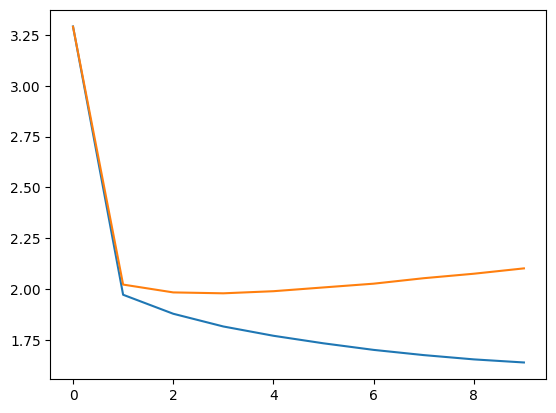

In [9]:
plt.plot(torch.tensor(tr_losses))
plt.plot(torch.tensor(val_losses))

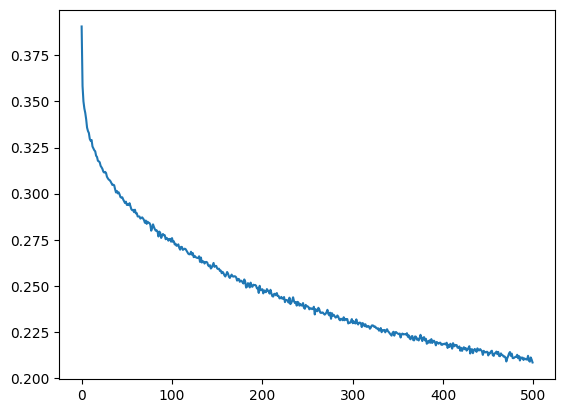

In [10]:
plt.plot(torch.tensor(lossi).view(-1, 100).mean(1))

In [11]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3060 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.7 GB
